Creating CNNs for image recognition with keras: binary and multi-classification

In this file, I create and train two variants of convolution neural networks - CNN: for multiclass classification (cat vs dog vs wild animal) and binary classification (man vs woman).

Each of the variants implies stages, such as:
- creating dataset;
- constructing CNN and training it;
- testing results.

I will start from multiclass classification.
As a dataset, I chose an animal faces dataset from Kaggle (https://www.kaggle.com/datasets/andrewmvd/animal-faces). More detailed description of the dataset is provided by the link. 
There are two folders - train (training set) and val(test set). I mark 3 classes with corresponding values, to be clear, vectors. [1,0,0] - cat, [0,1,0] - dog, [0,0,1] - wild. I use vectors since using single values for categorical data without gradation could be ambiguous for a model.

In [1]:
#save general directory
path = '/home/nyak/Desktop/scripts'

#create list of directories with corresponding classes
dirs = []
for currdir, dir, files in os.walk('afhq'):
    dirs.append(currdir)
#delete unnecessary directory
dirs = [item for item in dirs if item.count('/') > 1]
#create values list
vals = [[1,0,0], [0,1,0], [0,0,1]]

# #through this dictionary, we assign proper values for each example of 3 corresponding classes
animals = {}
for item, value in zip(dirs, vals * 2):
    for i in os.listdir(item):
      animals[f'{path}/{item}/{i}'] = value 

#split dictionary into train and test set
train_animals = {k:v for k,v in animals.items() if '/train/' in k}
test_animals = {k:v for k,v in animals.items() if '/val/' in k}

We also need to check the dataset for data imbalance. For this purpose let's plot number of examples of each class.

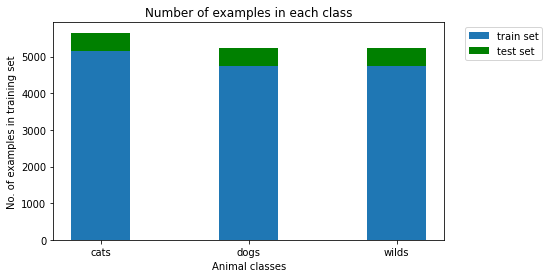

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#count number of examples for the classes in training and test set
cats = len([val for directory, val in train_animals.items() if 'cat' in directory])
dogs = len([val for directory, val in train_animals.items() if 'dog' in directory])
wilds = len([val for directory, val in train_animals.items() if 'wild' in directory])

cats_test = len([val for directory, val in test_animals.items() if 'cat' in directory])
dogs_test = len([val for directory, val in test_animals.items() if 'dog' in directory])
wilds_test = len([val for directory, val in test_animals.items() if 'wild' in directory])

#construct the plot
fig = plt.subplots(figsize =(7, 4))
plot1 = plt.bar(['cats', 'dogs', 'wilds'], [cats, dogs, wilds],
        width = 0.4)
plot2 = plt.bar(['cats', 'dogs', 'wilds'], [cats_test, dogs_test, wilds_test], bottom = [cats, dogs, wilds],
        width = 0.4, color = 'green')
plt.xlabel("Animal classes")
plt.ylabel("No. of examples")
plt.title("Number of examples in each class")
plt.legend((plot1[0], plot2[0]), ('train set', 'test set'), bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

Next step is to process images from training set. it's needed to upload each image, resize it and convert to 2d array (because we read images in grayscale, when read in color, it's 3-dimentional).Here and further I try to minimize computation cost since I don't have GPU on the current machine and have quite low CPU efficiency.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

training_data = []
#define a function for data processing   
def create_training_data():
    for img, value in zip(list(train_animals.keys()), list(train_animals.values())):  # iterate over each image per dogs and cats     
        try:
            img_array = cv2.imread((img) ,cv2.IMREAD_GRAYSCALE)  # convert to array (2d)
            new_array = cv2.resize(img_array, (100, 100))  # resize to normalize data size and reduce size of an array
            training_data.append([new_array, value])  # add to training set
            # plt.imshow(img_array, cmap='gray')  # optionally, graph image
            # plt.show()  # display image, it's better to use a break at the end of the loop or a slice 
            
        except Exception as e:  # in the interest in keeping the output clean...
            pass
    #since examples of classes in the inintial dataset go in order, it's needed to shuffle them
    random.shuffle(training_data)
create_training_data()
print(len(training_data))

#divide features and labels
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

#need to flatten the arrays in the training set since input values should be a vector
#print(X[0].reshape(-1, 100, 100, 1)) - if want to look how the array's element looks like
X = np.array(X).reshape(-1, 100, 100, 1)

#save the features and the values
import pickle

pickle_out = open("X_anim.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y_anim.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()


14630


Next step in to build a model itself. To build a CNN, convolution layers and pooling layers are needed. Also, dense layers can be added. I create  several lists to vary layer size, number of convolutonal and dense layers. Also we acn vary other parameters, such as learning rate, size of filters in convolution layer, size of pooling window, learning rate (default in adam is 0.001) and so on.

It is convenient to compare models using TensorBoard callback, which allows to show and compare models accuracy and loss.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import pickle
import time
import numpy as np

#open data that was saved
pickle_in = open("X_anim.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y_anim.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)

#normalize the features data, divide by 255 since color values range from 0 to 255
X = X/255.0

dense_layers = [2]
layer_sizes = [64] 
#for example, I tried layer_sizes = [32, 64, 128], also depends on CPU, can we afford more or not
conv_layers = [2]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            #create NAME variable to track models in callback
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()
            
            #use first convolution with standart filter size and max pooling
            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:], activation = 'relu'))
            model.add(MaxPooling2D(pool_size=(4, 4)))

            #add another layers optionally
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3), activation = 'relu'))
                model.add(MaxPooling2D(pool_size=(4, 4)))
            
            #convert previous layer to 1d array to pass to fully connected layer
            model.add(Flatten())
            
            #add dense (hidden) layers
            for _ in range(dense_layer):
                model.add(Dense(layer_size, activation = 'relu'))
            
            #add an output layer with 3 neurons - 3 classes
            model.add(Dense(3))
            #for multiclass classification a softmax function is used
            model.add(Activation('softmax'))

            #define a tensorboard object. To see the results, should type "ensorboard --logdir=logs/" in cmd window and follow the link
            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            
            #choose loss as categorical_crossentropy (since classification is multiclass), adam as a standart optimizer, accuracy as a metric
            model.compile(loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )
            #choose not big batch size and quite small number of epochs due to limited computation capabilities, 30% of training data is used as validation set
            model.fit(X, y,
                      batch_size=32,
                      epochs=10,
                      validation_split=0.3,
                      callbacks=[tensorboard])

2-conv-64-nodes-2-dense-1651845303
Epoch 1/10


2022-05-06 09:55:04.731421: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 409640000 exceeds 10% of free system memory.


320/321 [============================>.] - ETA: 0s - loss: 0.5322 - accuracy: 0.7623

2022-05-06 09:57:32.941578: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 175560000 exceeds 10% of free system memory.


321/321 [==============================] - 189s 586ms/step - loss: 0.5322 - accuracy: 0.7623 - val_loss: 0.2394 - val_accuracy: 0.9095
Epoch 2/10
321/321 [==============================] - 163s 509ms/step - loss: 0.1918 - accuracy: 0.9293 - val_loss: 0.1533 - val_accuracy: 0.9446
Epoch 3/10
321/321 [==============================] - 167s 520ms/step - loss: 0.1264 - accuracy: 0.9522 - val_loss: 0.1168 - val_accuracy: 0.9556
Epoch 4/10
321/321 [==============================] - 166s 519ms/step - loss: 0.1028 - accuracy: 0.9613 - val_loss: 0.1194 - val_accuracy: 0.9594
Epoch 5/10
321/321 [==============================] - 164s 510ms/step - loss: 0.0935 - accuracy: 0.9671 - val_loss: 0.1139 - val_accuracy: 0.9601
Epoch 6/10
321/321 [==============================] - 164s 510ms/step - loss: 0.0690 - accuracy: 0.9742 - val_loss: 0.1329 - val_accuracy: 0.9551
Epoch 7/10
321/321 [==============================] - 165s 512ms/step - loss: 0.0574 - accuracy: 0.9792 - val_loss: 0.1164 - val_accura

In [8]:
#save the model and see the summary
model.save('2x64x2-CNN_animals.model')
model.summary()

INFO:tensorflow:Assets written to: 2x64x2-CNN_animals.model/assets
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                     

After running models with different parameters we can check Tensorboard. In cmd, it shouls choose a directory where file with script is placed and type:
tensorboard --logdir=logs/ and follow the link apeared http://localhost:6006/

To clear the logs, it should type rm -rf ./logs/

Below I show how it looks for a current model. We should choose a model with the highest accuracy and the lowest loss. For example, we can see on the graph that model with 2 dense layers, 64 layer size and 2 convolution layers performs better compared to the other options.


![STATS](stats.png)

After training the model, it's time to check its performance. We can see the accuracy and loss for training and validation set. We would like to calculate accuracy of the test set.

In [9]:
import cv2
import tensorflow as tf
import numpy as np 

#define function that converts an image to an array to feed it the model
def prepare(filepath):
    IMG_SIZE = 100  
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

#load the model
model = tf.keras.models.load_model("2x64x2-CNN_animals.model")

#create two lists of predicted values and true values to compare them further
pred = []
true_val = []
for i,y in list(test_animals.items()):
  prediction = model.predict([prepare(i)])
  pred.append(prediction[0].astype(int))
  true_val.append(np.array(y))

#since in lists with labels there are np.arrays, it would be convenient to convert them to single numbers and compare
true_val_ind = []
predict_ind = []

for i,y in zip(true_val, pred):
    result1 = np.where(i == 1)  #find index of 1 in np.array in list with true labels
    result2 = np.where(y == 1)  #find index of 1 in np.array in list with predicted labels
    try:
      true_val_ind.append(result1[0][0]) 
      predict_ind.append(result2[0][0]) 
    except Exception:
        pass

#calculate accuracy as 1 - number of incorrect labels/total number of examples
print(f'Accuracy: {round(1 - sum(map(lambda x,y: bool(y-x),true_val_ind,predict_ind))/len(predict_ind),4)}')

Accuracy: 0.9586


So, we can see that 2x64x2-CNN_animals.model gives about 96% accuracy on test set. Optionally, if we want to check certain examples out of test set, we can adapt the function above for a single image.

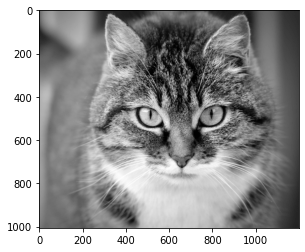

Cat


In [11]:
import cv2
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 

#create list of classes
CATEGORIES = ["Cat", "Dog", "Wild"]

#function to process image
def prepare(filepath):
    IMG_SIZE = 100 
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img_array, cmap='gray')  # optionally, graph image
    plt.show()
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

#load the model
model = tf.keras.models.load_model("2x64x2-CNN_animals.model")

#feed an image to the model
prediction = model.predict(prepare('cat.jpeg'))
#print class, which corresponds to prediction
print(CATEGORIES[np.where(prediction[0]== 1)[0][0]])


Also optionally, if we are interested to see, which examples in test set were recognized inorrectly. We can display several images and see, how they were recognized.

Number of incorrectly identified examples is 68
Dog is predicted as Wild


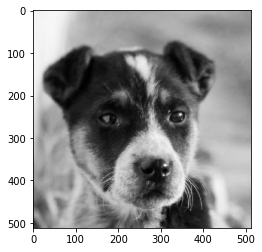

Cat is predicted as Wild


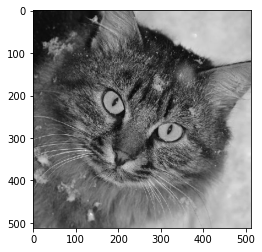

Wild is predicted as Dog


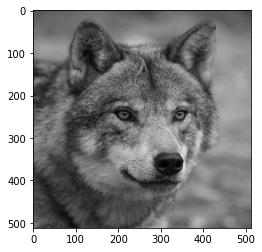

Dog is predicted as Wild


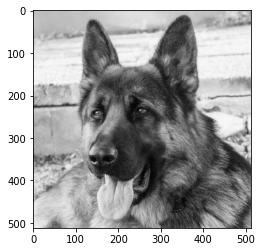

Wild is predicted as Dog


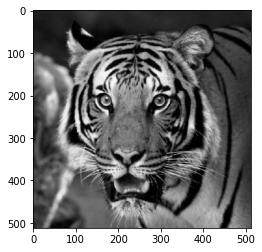

In [97]:
import matplotlib.pyplot as plt 
import random

CATEGORIES = ["Cat", "Dog", "Wild"]
indexes = []

#create list and append description and index of image
for lab1, lab2, index in zip(true_val_ind, predict_ind, range(len(true_val_ind))):
    if lab1 != lab2:
       indexes.append((f'{CATEGORIES[lab1]} is predicted as {CATEGORIES[lab2]}', index))
print(f'Number of incorrectly identified examples is {len(indexes)}')

#choose randomly 5 images and show them
for string, index in random.sample(indexes,k=len(indexes))[:5]:
    img = list(test_animals.keys())[index]
    img_array = cv2.imread((img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
    new_array = cv2.resize(img_array, (100, 100))  # resize to normalize data size
            
    plt.imshow(img_array, cmap = 'gray')
    print(string)
    plt.show()  

The second task is to build a model that distinguishes men faces from women faces. For this purpose I use faces dataset (http://vis-www.cs.umass.edu/lfw/#download) and download entire dataset as zip file. Since images of men and women are in the same directory, it needs to asign a label on one's own. I wrote a small app on tkinter which helps to speed up the process and marks a first image in each folder by 0 or 1 (woman or man), results are appended to a list. You see an image, press 'left' on a keyboard - list appends 0 (woman), press 'right' - list appends 1 (man). Finally, the result is written to a file. Since it's quite long to mark the data anyway, I will attach a final file.

In [8]:
from tkinter import*
from PIL import ImageTk, Image
path = '/home/nyak/Desktop/scripts/faces1'

#create an empty dict
dict_gender = {}

#define functions 
# if there is a man on the image - assign value 1 to his name and move to the next image
def man_detected():
    global name
    dict_gender[name] = 1
    try:
        img = next(images)  # get the next image from the iterator
        name = next(names)   
    except StopIteration:
        return  # if there are no more images, do nothing
    
    img = Image.open(img)
    img = ImageTk.PhotoImage(img)
    panel.img = img  # keep a reference so it's not garbage collected
    panel['image'] = img
    text.set(name)
    
# if there is a woman on the image - assign value 0 to her name and move to the next image
def woman_detected():
    global name
    dict_gender[name] = 0
    try:
        img = next(images)  # get the next image from the iterator
        name = next(names)   
    except StopIteration:
        return  # if there are no more images, do nothing
    
    img = Image.open(img)
    img = ImageTk.PhotoImage(img)
    panel.img = img  # keep a reference so it's not garbage collected
    panel['image'] = img
    text.set(name)

#function for initializing the app   
def next_img():
    global name 
    try:
        img = next(images)  # get the next image from the iterator
        name = next(names)   
    except StopIteration:
        return  # if there are no more images, do nothing
    
    img = Image.open(img)
    img = ImageTk.PhotoImage(img)
    panel.img = img  # keep a reference so it's not garbage collected
    panel['image'] = img
    text.set(name)

#Tkinter app structure
window = Tk()
window.title("Faces")
window.geometry('300x300')  # set window size
window.resizable(0, 0)

panel = Label(window)
panel.pack()
text = StringVar()
label_name = Label(window, textvariable=text)
label_name.pack()

#walking through directories and append images and names
images = []
names = []
for currdir, dir, files in os.walk('faces1'):
      for item in sorted(dir):
        route = f'{path}/{item}/{item}_0001.jpg'
        images.append(route) 
        names.append(item)

images = iter(images) 
names = iter(names)

#assign functions to the buttons on the keyboard
window.bind("<Left>", lambda e:woman_detected())
window.bind("<Right>", lambda e:man_detected())

next_img() 

window.mainloop()

A disadvantage of this approach is that it's quite a long process to mark all the images and there is high probability to make an error. I also made several mistakes, so I wrote down places where I nade mistakes and corrected them in the file.

In [10]:
#save the dictionary to a file
with open('marked_data', 'w') as file:
   file.write(str(dict_gender)) 

Next step is to create and save training data. The algorythm used is similar to the previous example. Since data in the previous example is quite balanced, it's not needed to use weights or to reorganize sample. However, in the faces dataset male to female photo ratio is inequal, we can see in on a graph below, so it's needed to take it into account. Below I consider 2 options: using weights for classes and undersampling men's class to achieve equal ratio. First, let's consider an option with weights.

In [13]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle

DATADIR = '/home/nyak/Desktop/scripts/faces1'

#read the dictionary saved in the file
marked_data = {}
with open('marked_data', 'r') as file:
    text = file.read()
text = text[1:-2]
text_list = text.split(',')
for line in text_list:
   key, value = line.split(':')
   marked_data[key] = value

values = [int(item) for item in marked_data.values()]

#create list of all files in all directories
files_list = []
for currdir, dir, files in os.walk('faces1'):
    files_list.append(files) 

#spread values assigned to each first image in folders to all the images
dict_final = {}
for num, file in list(zip(values, sorted(files_list)[1:])):
    for i in file:
       dict_final[i] = num 


training_data = []  
#function to process the data 
def create_training_data():
    for img, value in zip(list(dict_final.keys()), list(dict_final.values())):  # iterate over each image per dogs and cats  
        try:
            img_array = cv2.imread(os.path.join(DATADIR,img[:-9],img) ,cv2.IMREAD_REDUCED_GRAYSCALE_4)  # convert to array
            new_array = cv2.resize(img_array, (100, 100))  # resize to normalize data size
            training_data.append([new_array, value])  # add this to our training_data
            # plt.imshow(img_array, cmap='magma')  # graph it
            # plt.show()  # display!
            
        except Exception as e:  # in the interest in keeping the output clean...
            pass

create_training_data()

#split the data to training and test set, cutting 20% from the initial dataset
training_data_new = training_data[:int(len(training_data)*0.8)]
test_data = training_data[int(len(training_data)*0.8):]

#show size of training (including validation) and test set
print(f'Number of training examples: {len(training_data_new)}')
print(f'Number of test examples: {len(test_data)}')

Number of training examples: 10585
Number of test examples: 2647


We can see significant disproportion in examples numbers. Let's plot it.

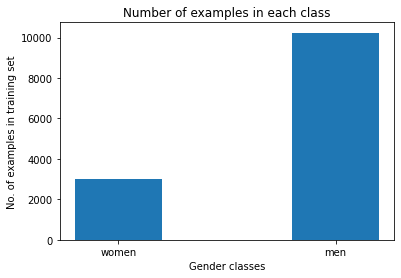

In [14]:
#count occurencies of men and women in the dataset
women = len([val for directory, val in dict_final.items() if val == 0])
men = len([val for directory, val in dict_final.items() if val ==1])

#drawing a bar plot
plt.bar(['women', 'men'], [women, men],
        width = 0.4)
 
plt.xlabel("Gender classes")
plt.ylabel("No. of examples in training set")
plt.title("Number of examples in each class")
plt.show()

So, we calculate weights and save the features and labels to files.

In [3]:
#calculate weights to take into account inequality in ratio of men and women fhotos
# Scaling by total/2 helps keep the loss to a similar magnitude.
weight_for_0 = (1 / values.count(0)) * (len(values) / 2.0)
weight_for_1 = (1 / values.count(1)) * (len(values) / 2.0)

#model will "pay more attention" to the undersampled class
weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

#create additional randomness in the data
random.shuffle(training_data_new)

#create and save features and labels
X = []
y = []

for features,label in training_data_new:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, 100, 100, 1)

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

Weight for class 0: 1.93
Weight for class 1: 0.68


As in the example above, I construct a model and try different structures. Since it's a case of binary classification, the function is used - sigmoid function and binary_crossentropy as a loss function. Also I train the model taking into account the weights of the classes.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
import numpy as np

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)

X = X/255.0

dense_layers = [1]
#layer_sizes = [32, 64, 128]
layer_sizes = [64] 
conv_layers = [2]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "People{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=10,
                      validation_split=0.2,
                      callbacks=[tensorboard], class_weight = weights)

2022-05-06 04:15:39.810289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nyak/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-06 04:15:39.810351: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


People2-conv-64-nodes-1-dense-1651824945


2022-05-06 04:15:45.678657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nyak/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-06 04:15:45.678697: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-06 04:15:45.678730: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nyak-ThinkPad-X220): /proc/driver/nvidia/version does not exist
2022-05-06 04:15:46.634770: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 338720000 exceeds 10% of free system memory.


Epoch 1/10


2022-05-06 04:15:48.268497: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 78675968 exceeds 10% of free system memory.
2022-05-06 04:15:48.680644: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30537216 exceeds 10% of free system memory.
2022-05-06 04:15:49.151673: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 39337984 exceeds 10% of free system memory.
2022-05-06 04:15:49.151769: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 78675968 exceeds 10% of free system memory.


265/265 [==============================] - 319s 1s/step - loss: 0.4976 - accuracy: 0.7384 - val_loss: 0.3949 - val_accuracy: 0.8035
Epoch 2/10
265/265 [==============================] - 375s 1s/step - loss: 0.3472 - accuracy: 0.8386 - val_loss: 0.3510 - val_accuracy: 0.8413
Epoch 3/10
265/265 [==============================] - 399s 2s/step - loss: 0.2666 - accuracy: 0.8845 - val_loss: 0.2714 - val_accuracy: 0.8838
Epoch 4/10
265/265 [==============================] - 328s 1s/step - loss: 0.2105 - accuracy: 0.9101 - val_loss: 0.2838 - val_accuracy: 0.8687
Epoch 5/10
265/265 [==============================] - 341s 1s/step - loss: 0.1633 - accuracy: 0.9309 - val_loss: 0.2503 - val_accuracy: 0.8984
Epoch 6/10
265/265 [==============================] - 332s 1s/step - loss: 0.1217 - accuracy: 0.9480 - val_loss: 0.2670 - val_accuracy: 0.9051
Epoch 7/10
265/265 [==============================] - 355s 1s/step - loss: 0.1048 - accuracy: 0.9562 - val_loss: 0.4001 - val_accuracy: 0.8351
Epoch 8/10

In [5]:
#save the model and show  information
model.save('1x64x2-CNN.model')
model.summary()

2022-05-06 05:28:40.102449: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: 1x64x2-CNN.model/assets
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 activation (Activation)     (None, 98, 98, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 47, 47, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0       

Let's save the model and try the second option - create equal number of examples in each class by undersampling men class. All the steps are the same, except reducing number of examples in the dictionary.

In [14]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
import itertools 

DATADIR = '/home/nyak/Desktop/scripts/faces1'

#read the dictionary saved in the file
marked_data = {}
with open('marked_data', 'r') as file:
    text = file.read()
text = text[1:-2]
text_list = text.split(',')
for line in text_list:
   key, value = line.split(':')
   marked_data[key] = value

values = [int(item) for item in marked_data.values()]

#create list of all files in all directories
files_list = []
for currdir, dir, files in os.walk('faces1'):
    files_list.append(files) 

#spread values assigned to each first image in folders to all the images
dict_final = {}
for num, file in list(zip(values, sorted(files_list)[1:])):
    for i in file:
       dict_final[i] = num 

#extract from the dict only men (items with value 1)
men_dict = {k:v for k,v in dict_final.items() if v == 1}
#since some photos of one person go by order, it's better to shuffle the data for more diversity
l = list(men_dict.items())
random.shuffle(l)
men_dict = dict(l)

#extract from the dict only women (items with value 0)
women_dict = {k:v for k,v in dict_final.items() if v == 0}

#make a slice of men dict, to make number of examples equal
men_dict = dict(itertools.islice(men_dict.items(), len(women_dict.items())))

#join men and women dictionaries into one
dict_final = dict(men_dict)
dict_final.update(women_dict)

training_data = []  
#function to process the data 
def create_training_data():
    for img, value in zip(list(dict_final.keys()), list(dict_final.values())):  # iterate over each image per dogs and cats  
        try:
            img_array = cv2.imread(os.path.join(DATADIR,img[:-9],img) ,cv2.IMREAD_REDUCED_GRAYSCALE_4)  # convert to array
            new_array = cv2.resize(img_array, (100, 100))  # resize to normalize data size
            training_data.append([new_array, value])  # add this to our training_data
            # plt.imshow(img_array, cmap='magma')  # graph it
            # plt.show()  # display!
            
        except Exception as e:  # in the interest in keeping the output clean...
            pass

create_training_data()

#split the data to training and test set, cutting 20% from the initial dataset
training_data_new = training_data[:int(len(training_data)* 0.8)]
test_data = training_data[int(len(training_data)* 0.8):]
#show size of training (including validation) and test set
print(f'Number of training examples: {len(training_data_new)}')
print(f'Number of test examples: {len(test_data)}')

#create additional randomness in the data
random.shuffle(training_data_new)

#create and save features and labels
X = []
y = []

for features,label in training_data_new:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, 100, 100, 1)

#I save the data to files with other names
pickle_out = open("X_equal.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y_equal.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

Number of training examples: 4784
Number of test examples: 1196


We run the model with the same hyperparameters as in the previous example but without weights parameter in model.compile.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
import numpy as np

pickle_in = open("X_equal.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y_equal.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)

X = X/255.0

dense_layers = [1]
#layer_sizes = [32, 64, 128]
layer_sizes = [64] 
conv_layers = [2]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            #add "equal" to the name to distinguish the models
            NAME = "People_equal {}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=10,
                      validation_split=0.2,
                      callbacks=[tensorboard])

People_equal 2-conv-64-nodes-1-dense-1651829352
Epoch 1/10
120/120 [==============================] - 131s 1s/step - loss: 0.5786 - accuracy: 0.6901 - val_loss: 0.4501 - val_accuracy: 0.7743
Epoch 2/10
120/120 [==============================] - 127s 1s/step - loss: 0.4227 - accuracy: 0.7975 - val_loss: 0.4115 - val_accuracy: 0.8161
Epoch 3/10
120/120 [==============================] - 134s 1s/step - loss: 0.3333 - accuracy: 0.8529 - val_loss: 0.3773 - val_accuracy: 0.8265
Epoch 4/10
120/120 [==============================] - 139s 1s/step - loss: 0.2831 - accuracy: 0.8782 - val_loss: 0.3948 - val_accuracy: 0.8454
Epoch 5/10
120/120 [==============================] - 138s 1s/step - loss: 0.2274 - accuracy: 0.9099 - val_loss: 0.3364 - val_accuracy: 0.8600
Epoch 6/10
120/120 [==============================] - 145s 1s/step - loss: 0.1740 - accuracy: 0.9261 - val_loss: 0.3336 - val_accuracy: 0.8683
Epoch 7/10
120/120 [==============================] - 141s 1s/step - loss: 0.1379 - accuracy: 

In [7]:
model.save('1x64x2-CNN_equal.model')

INFO:tensorflow:Assets written to: 1x64x2-CNN_equal.model/assets


We can see that the model with weights shows better accuracy and loss values than the model with smaller sample but equal proportion of clases in general. Choosing between different models with weights using tensorboard I can see that model with 1 dense layer, 2 convolution layers and 64 nodes layer size performs the best, considering balance between high accuracy and low loss. The same model with 128 nodes layer size is more prone to overfitting since with increasing number of iterations validation loss takes off more rapidly. However, it has higher accuracy by the end of 10th epoch. Finally, we estimate how the model works on the test set. We can test several models. For example, model 1 dense x 64 layer size x 2 convolution layers shows acuracy about 88,5% below, the same model with 64 layer size accuracy is 83%. 

In [11]:
import tensorflow as tf

#function to flatten values in X test set
def prepare(array):
    return array.reshape(-1, 100, 100, 1)

#upload model
model = tf.keras.models.load_model("1x128x2-CNN.model")

#create two lists - of predicted values and true values
predict= []
true_value = []
for i,y in test_data:
    prediction = model.predict([prepare(i)])
    predict.append(int(prediction[0][0]))
    true_value.append(y)

#calculate accuracy 
print(f'Accuracy: {round(1 - sum(map(lambda x,y: bool(x-y),predict,true_value))/len(true_value),4)}')

Accuracy: 0.8855


By analogy with animals example, if we want to use model for a single image prediction, we can use code below. The photos are attached in the folder.

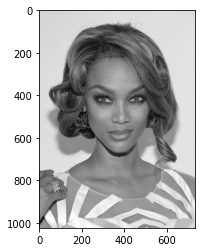

Woman


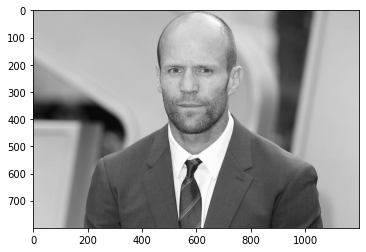

Man


In [44]:
import cv2
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 

#create list of classes
CATEGORIES = ["Woman", "Man"]

#function to process image
def prepare(filepath):
    IMG_SIZE = 100 
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img_array, cmap='gray')  # optionally, graph image
    plt.show()
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

#load the model
model = tf.keras.models.load_model("1x64x2-CNN.model")

#feed an image to the model
prediction = model.predict(prepare('tyra.jpg'))
#print class, which corresponds to prediction
print(CATEGORIES[int(prediction[0][0])])

prediction1 = model.predict(prepare('jason.jpg'))
print(CATEGORIES[int(prediction1[0][0])])


References:
1.Animal Faces. Kaggle. https://www.kaggle.com/datasets/andrewmvd/animal-faces

2.Gary B. Huang, Manu Ramesh, Tamara Berg, and Erik Learned-Miller.
Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments.
University of Massachusetts, Amherst, Technical Report 07-49, October, 2007. http://vis-www.cs.umass.edu/lfw/#download

3.Python programming tutorials. Loading in your own data - Deep Learning basics with Python, TensorFlow and Keras p.2 https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/?completed=/introduction-deep-learning-python-tensorflow-keras/ 

4.Get started with TensorBoard. https://www.tensorflow.org/tensorboard/get_started

5.https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53